# Milestone: LightGCN Course Recommender
Borrows code from Hikaru Hotta and Ada Zhou, https://medium.com/stanford-cs224w/lightgcn-with-pytorch-geometric-91bab836471e

In [1]:
import json
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling, negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing

## Load Dataset

In [2]:
with open('new_planned_courses.json') as f:
    planned_courses = json.load(f)
course_counter = {}

# Iterating through each student's data to count enrollments and courses, excluding 'Unplanned'
for student, quarters in planned_courses.items():
    for quarter, courses in quarters.items():
        if (quarter != 'None'):
            # Counting course frequency
            for course in courses:
                if course== 'RESTRICTED':
                    continue
                if not (course in course_counter):
                    course_counter[course] = 1
                else:
                    course_counter[course] += 1  
                    
# course_counter
min_enrollments_thre = 4
course_count_df = pd.DataFrame(course_counter.items(), columns=['Course', 'Enrollments'])
course_count_df = course_count_df.drop(index=course_count_df[course_count_df.Enrollments < min_enrollments_thre].index)
selected_courses = list(course_count_df.Course)

In [3]:
userIds = {}
courseIds = {}
numEdges = 0
min_courses_thre = 4

# clean up data, create userIds and courseIds
num_course_each_student = []
Ids = []

for user in list(planned_courses.keys()):
    
    # Pt.1 we count the total amount of courses each user already took
    # and we get rid of the users with only a few course pinned
    num = 0
    for quarter in planned_courses[user]:
        num += len(planned_courses[user][quarter])
    
    if num < min_courses_thre:
        del planned_courses[user]
        continue
    else:
        userIds[user] = len(userIds)
    
    #Pt.2 build the userIds and CourseIds dict
    for quarter in planned_courses[user]:
        numEdges += len(planned_courses[user][quarter])
        for course in planned_courses[user][quarter]:
            if course== 'RESTRICTED' or (course not in selected_courses):
                numEdges -= 1
                continue
            if (course not in courseIds) :
                courseIds[course] = len(courseIds)
    Ids.append(len(userIds))
    num_course_each_student.append(num)

#The course' IDs will be followed after the user's IDs

for item in courseIds:
    courseIds[item] += len(userIds)

print('# of real users:', len(userIds))
print('# of courses:', len(courseIds))
print('# of edges:', numEdges)

# of real users: 1895
# of courses: 1518
# of edges: 27086


In [4]:
# create edge_index
j = 0
edge_index = torch.zeros((2, numEdges), dtype=int)
train_edge_index = []
val_edge_index_sup = []

for user in planned_courses:
    user_edge_index = []
    for quarter in planned_courses[user]:
        for course in planned_courses[user][quarter]:
            if (course== 'RESTRICTED') or (course not in selected_courses):
                continue
            edge_index[0][j] = userIds[user]
            edge_index[1][j] = courseIds[course]
            user_edge_index.append((userIds[user], courseIds[course]))
            j += 1
            
    # Here we split 
    user_num_courses = len(user_edge_index)
    user_train_indices = random.sample([i for i in range(user_num_courses)], k=int(0.8*user_num_courses))
    user_val_indices = list(set([i for i in range(user_num_courses)]) - set(user_train_indices))
    train_edge_index += [user_edge_index[i] for i in user_train_indices]
    val_edge_index_sup += [user_edge_index[i] for i in user_val_indices]
    
train_edge_index = torch.tensor(train_edge_index).T
val_edge_index_sup = torch.tensor(val_edge_index_sup).T
val_edge_index_msg = train_edge_index
train_edge_index.shape, val_edge_index_sup.shape

(torch.Size([2, 20991]), torch.Size([2, 6095]))

In [5]:
# split the edges of the graph using a 80/20 train/validation split
num_users, num_courses = len(userIds), len(courseIds)
numNodes = num_users + num_courses
# all_edge_indices = [i for i in range(numEdges)]

# train_edge_indices, val_edge_indices_sup = train_test_split(all_edge_indices, test_size=0.2, random_state=1)
# # the validation msg is supposed to be the entire training edge set. 
# # we'll be dividing the training edge set into msg set and sup set later
# val_edge_indices_msg = train_edge_indices

# train_edge_index = edge_index[:, train_edge_indices]
# val_edge_index_msg   = edge_index[:, val_edge_indices_msg]
# val_edge_index_sup   = edge_index[:, val_edge_indices_sup]

train_sparse_edge_index = SparseTensor(row=train_edge_index[0], 
                                       col=train_edge_index[1], 
                                       sparse_sizes=(numNodes, numNodes))
val_sparse_edge_index_msg = SparseTensor(row=val_edge_index_msg[0], 
                                         col=val_edge_index_msg[1], 
                                         sparse_sizes=(numNodes, numNodes))
val_sparse_edge_index_sup = SparseTensor(row=val_edge_index_sup[0], 
                                         col=val_edge_index_sup[1], 
                                         sparse_sizes=(numNodes, numNodes))

In [6]:
# function which random samples a mini-batch of positive and negative samples
edge_set = set([tuple(edge) for edge in edge_index.t().tolist()])
    
def negative_sampling(edge_index, num_users, num_items, neg_per_person=1):

    # Prepare for negative sampling
    # Detect non-isolated users and items
    # non_isolated_users = set(edge_index[0].tolist())
    # non_isolated_items = set(edge_index[1].tolist())
    negative_edges = []
    for j in range(neg_per_person):
        for i in range(len(edge_index[0])):
            user = edge_index[0,i]
            pos_item = edge_index[1, i]
            # Sample negative items for each user
            while True:
                negative_item = random.randint(num_users, num_users + num_items - 1)
                # if negative_item not in non_isolated_items:
                #     continue  # Skip isolated items
                if (user, negative_item) not in edge_set:
                    negative_edges.append([user, pos_item, negative_item])
                    break

    return torch.tensor(negative_edges).t()


def sample_mini_batch(batch_size, edge_index, negative_edges):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges
        negative_edges (torch.Tensor): 3 by N list of edges, 
                0-user indices, 1-positive item indices, 2-negative item indices

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    
    # if we have already done the negative sampling somewhere else we kip this part
    # otherwise we need to do the negative smapling
    if negative_edges is None:
        negative_edges = negative_sampling(train_edge_index, num_users=num_courses, num_items=num_courses)

    # get a mini_batch of it
    indices = random.sample([i for i in range(len(negative_edges[0]))], k=batch_size)
    batch = negative_edges[:, indices]
    
    # Node, all of the courseIds are followed by the userIds
    # So for convenience, we subtract the courseIds by num_users 
    # so that courseIds are from 0 to num_courses, which helps with extracting the course embeddings
    user_indices, pos_item_indices, neg_item_indices= batch[0], batch[1] - num_users, batch[2] - num_users
    
    return user_indices, pos_item_indices, neg_item_indices

## Load Embeddings

In [7]:
# embeddings

In [8]:
import pickle
with open('embeddings32_2023-12-09.pkl', 'rb') as f:
    embeddings = pickle.load(f)
    
embedding_length = len(embeddings['CS224W'])

In [9]:
embeddings_mat = np.zeros((num_courses, embedding_length))
course_no_info = []
print('Courses without embeddings')
for one_course in courseIds:
    if one_course not in embeddings:
        print(one_course)
        course_no_info.append(courseIds[one_course]-num_users)
        continue
    # if one_course == 'CS144':
    #     print(courseIds[one_course]-num_users)
    embeddings_mat[courseIds[one_course]-num_users] = np.array(embeddings[one_course])
embeddings_mat = torch.tensor(embeddings_mat)

# For those courses without embeddings, use the averaged embedding of all course as their embeddings
ave = torch.mean(embeddings_mat, axis=0)
embeddings_mat[course_no_info] = ave
embeddings_mat = embeddings_mat.type(torch.float32)

# Normalize the data. The embeddings we have are aleady 0 mean
embeddings_mat = embeddings_mat/embeddings_mat.std()

Courses without embeddings
ME110
GEOLSCI1
PHYSICS40


## Model

In [10]:
# defines LightGCN model
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, course_ada_emb=embeddings_mat, embedding_dim=64, K=3, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops
        self.cours_ada_emb = course_ada_emb
        ada_emb_len = course_ada_emb.shape[-1]
        
        # pre_diffusion embedding will be used for regularization computing
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0
        self.emb_transform = nn.Sequential(nn.Linear(in_features=ada_emb_len, out_features=embedding_dim),
                                           nn.GELU(),
                                           nn.LayerNorm(embedding_dim),
                                           nn.Linear(in_features=embedding_dim, out_features=embedding_dim),
                                           nn.GELU(),
                                           nn.LayerNorm(embedding_dim))
        self.score_mat = nn.Parameter(torch.eye(embedding_dim),requires_grad=False)
        
        # embedding after multi-scale diffusion
        # this will be used to give final recommendation/compute brp loss
        self.users_emb_final = None
        self.items_emb_final = None
        

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor, weight=1):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(edge_index, add_self_loops=self.add_self_loops)
        
        course_ada_emb = self.emb_transform(self.cours_ada_emb)
        course_emb = course_ada_emb * weight + self.items_emb.weight

        emb_0 = torch.cat([self.users_emb.weight, course_emb]) # E^0
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K
        
        self.users_emb_final = users_emb_final
        self.items_emb_final = items_emb_final
        # rating_mat = torch.matmul(users_emb_final, items_emb_final.T)
        # returns the embedding of both the original and after multiscale diffusion
        
        return users_emb_final, self.users_emb.weight, items_emb_final,  self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        return matmul(adj_t, x)

In [11]:
def bpr_loss(model, users_emb_final, users_emb_0, 
             pos_items_emb_final, pos_items_emb_0, 
             neg_items_emb_final, neg_items_emb_0, lambda_val):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss
    epsilon = 1e-7
    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    # pos_scores = torch.trace(users_emb_final @ model.score_mat @ pos_items_emb_final.T)
    # pos_scores = weighted_dot_product(users_emb_final, pos_items_emb_final, model.score_mat)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    # neg_scores = torch.trace( users_emb_final @ model.score_mat @ neg_items_emb_final.T )
    # neg_scores = weighted_dot_product(users_emb_final, neg_items_emb_final, model.score_mat)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    # loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss
    loss = -torch.sum(torch.log(torch.sigmoid(pos_scores - neg_scores)+epsilon)) + reg_loss
    
    
#     pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
#     # pos_scores = users_emb_final @ model.score_mat @ pos_items_emb_final.T
#     pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
#     neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
#     # neg_scores = users_emb_final @ model.score_mat @ neg_items_emb_final.T
#     neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

#     # loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss
#     loss2 = -torch.sum(torch.log(torch.sigmoid(pos_scores - neg_scores)))

    return loss

## Evaluation

In [12]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        dict: dictionary of positive items for each user
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [13]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [14]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [15]:
# wrapper function to get evaluation metrics
def get_metrics(model, users_emb_final, items_emb_final, edge_index_msg, edge_index_sup, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        users_emb_final: usr emb after multi-scale diff
        items_emb_final: usr emb after multi-scale diff
        edge_index_msg (torch.Tensor): 2 by N list of edges for split to compute the emb
        edge_index_sup (torch.Tensor): 2 by N list of edges for split to supervise
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """

    # as in the intialize part, we add the courseIDs with num_Users for the convience of GNN training convience
    # here we subtract the num_Users for each courseIDs, for the convenience of emb extraction
    # As this varible edge_index will be send to the cpu/gpu, here this variable serves as an index of extracting 
    # emb, we don't want to change it so we clone it and then make modification
    edge_index_msg_cpy = edge_index_msg.clone()
    edge_index_sup_cpy = edge_index_sup.clone()
    edge_index_msg_cpy[1] -= num_users
    edge_index_sup_cpy[1] -= num_users
    
    all_indices = torch.concat((edge_index_msg_cpy, edge_index_sup_cpy), dim=1)
    user_indices_all = all_indices[0].unique()
    item_indices_all = all_indices[1].unique()
    
    #get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(users_emb_final, items_emb_final.T)
    # rating = users_emb_final @ model.score_mat @  items_emb_final.T
    # rating = weighted_dot_product(users_emb_final,items_emb_final, model.score_mat)
    # rating = users_emb_final @ model.score_mat @ items_emb_final.T
    # plt.imshow((torch.matmul(users_emb_final, items_emb_final.T) - rating).detach().numpy())
    
    # for recall/precision/ndcg computing, we exclude those message edges first
    exclude_edge_index = edge_index_msg_cpy
    #      gets all the positive items for each user from the edge index
    user_pos_items = get_user_positive_items(exclude_edge_index)
    #      get coordinates of all edges to exclude
    exclude_users = []
    exclude_items = []
    for user, items in user_pos_items.items():
        exclude_users.extend([user] * len(items))
        exclude_items.extend(items)

    #       set ratings of excluded edges to large negative value
    rating[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index_sup_cpy[0,:].unique()

    test_user_pos_items = get_user_positive_items(edge_index_sup_cpy)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [16]:
def weighted_dot_product(A, B, W):
    # Reshape A and B for batch matrix multiplication
    A = A.unsqueeze(1)  # Shape: [N, 1, dim]
    B = B.unsqueeze(2)  # Shape: [M, dim, 1]

    # Apply the weight matrix
    weighted_A = torch.bmm(A, W.unsqueeze(0).expand(A.size(0), *W.size()))  # Shape: [N, 1, dim]

    # Perform the weighted dot product
    result = torch.bmm(weighted_A, B)  # Shape: [N, 1, 1]

    # Squeeze the result to get a [N] vector
    result = result.squeeze()  # Shape: [N]
    return result

In [17]:
# wrapper function to evaluate model
def evaluation(model, edge_index_msg, edge_index_sup, sparse_edge_index, k, lambda_val):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index_msg: (torch.Tensor): 2 by N list of edges for split to compute final embedding
        edge_index_sup: (torch.Tensor): 2 by N list of edges for split to supervise
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(sparse_edge_index)
    
    edges = negative_sampling(edge_index_msg, num_items=num_courses, num_users=num_users)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1]-num_users, edges[2]-num_users
    users_emb_final_set, users_emb_0_set = users_emb_final[user_indices], users_emb_0[user_indices]
    
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(model, users_emb_final_set, users_emb_0_set, 
                    pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val)
    
    # print(pos_items_emb_final.shape, users_emb_final_set.shape)

    recall, precision, ndcg = get_metrics(model, users_emb_final, items_emb_final, edge_index_msg, edge_index_sup, k)

    return loss.item(), recall, precision, ndcg

## Training

In [18]:
# define contants
ITERATIONS = 32001
BATCH_SIZE = 256
LR = 0.1
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
k = 20 #number of recommendations
LAMBDA = 1e-5
embedding_dim=32
K=5 #multiscale diffusion

# setup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index_msg = val_edge_index_msg.to(device)
val_edge_index_sup = val_edge_index_sup.to(device)
val_sparse_edge_index_msg = val_sparse_edge_index_msg.to(device)

Using device cuda.


In [19]:
from tqdm import tqdm
model = LightGCN(num_users, num_courses, course_ada_emb=embeddings_mat.to(device), embedding_dim=embedding_dim, K=K)
model = model.to(device)
model.train()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

In [20]:
# training loop
train_msg_losses = []
train_losses = []
val_losses = []

train_ndcgs = []
val_ndcgs = []

train_recalls = []
val_recalls = []

train_precisions = []
val_precisions = []

print("@"+str(k)+" recommendation")
for iter in tqdm(range(ITERATIONS), desc='Training', leave=True):
    
    
    # Modified on Dec 2nd: Evaluate on train_sup set
    # forward propagation train_sparse_edge_msg_index
    if iter<0:
        weight = 0
    else: 
        weight = 1
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_sparse_edge_index, weight=weight)
    
    # mini batching
    # Modified on Dec 2nd: Evaluate on train_sup set
    if iter % ITERS_PER_EVAL == 0:
        # sample once, use the negative samples for multiple iterations
        negative_edges = negative_sampling(edge_index, num_users, num_courses, neg_per_person=10)
        
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, train_edge_index, negative_edges)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_msg_loss = bpr_loss(model, users_emb_final, users_emb_0, 
                              pos_items_emb_final, pos_items_emb_0, 
                              neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_msg_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        
        #Modified on Dec 2nd: Evaluate on train_sup set
        length = train_edge_index.shape[1] - val_edge_index_sup.shape[1]
        temp_train_edge_msg = random.sample([i for i in range(len(train_edge_index[0]))], k=length)
        temp_train_edge_sup = list(set([i for i in range(len(train_edge_index[0]))]) - set(temp_train_edge_msg))
        temp_train_edge_msg = train_edge_index[:,temp_train_edge_msg]
        temp_train_edge_sup = train_edge_index[:,temp_train_edge_sup]
        temp_train_sparse_edge_msg = SparseTensor(row=temp_train_edge_msg[0], 
                                                  col=temp_train_edge_msg[1], sparse_sizes=(numNodes, numNodes))
        temp_train_sparse_edge_msg = temp_train_sparse_edge_msg.to(device)
        train_loss, train_recall, train_precision, train_ndcg = evaluation(model, 
                                                                           temp_train_edge_msg, 
                                                                           temp_train_edge_sup, 
                                                                           temp_train_sparse_edge_msg, 
                                                                           k, LAMBDA)
        
        val_loss, val_recall, val_precision, val_ndcg = evaluation(model, 
                                                                   val_edge_index_msg, 
                                                                   val_edge_index_sup, 
                                                                   val_sparse_edge_index_msg, 
                                                                   k, LAMBDA)
        
        
        l1 = f"[Iteration {iter}/{ITERATIONS}] train_msg_loss: {round(train_msg_loss.item(), 5)}, train_loss: {round(train_loss, 5)}, val_loss: {round(val_loss, 5)}"
        l2 = f"tr_re: {round(train_recall, 5)}, tr_pre: {round(train_precision, 5)}, tr_nd: {round(train_ndcg, 5)},"
        l3 = f"v_re: {round(val_recall, 5)}, v_pre: {round(val_precision, 5)}, v_nd: {round(val_ndcg, 5)},"

        print(l1)
        print(l2, l3)
        train_msg_losses.append(train_msg_loss.item())
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        train_ndcgs.append(train_ndcg)
        val_ndcgs.append(val_ndcg)
        
        train_recalls.append(train_recall)
        val_recalls.append(val_recall)
        
        train_precisions.append(train_precision)
        val_precisions.append(val_precision)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

@20 recommendation


Training:   0%|          | 0/32001 [00:00<?, ?it/s]

Training:   0%|          | 13/32001 [00:11<5:45:11,  1.54it/s] 

[Iteration 0/32001] train_msg_loss: 177.34428, train_loss: 10324.85645, val_loss: 14548.91699
tr_re: 0.01545, tr_pre: 0.00288, tr_nd: 0.0092, v_re: 0.02032, v_pre: 0.00313, v_nd: 0.01046,


Training:   1%|          | 217/32001 [00:24<1:47:45,  4.92it/s]

[Iteration 200/32001] train_msg_loss: 72.16062, train_loss: 4005.45337, val_loss: 5589.90723
tr_re: 0.35855, tr_pre: 0.06343, tr_nd: 0.2351, v_re: 0.37428, v_pre: 0.05591, v_nd: 0.24667,


Training:   1%|▏         | 421/32001 [00:37<1:45:48,  4.97it/s]

[Iteration 400/32001] train_msg_loss: 47.82937, train_loss: 2517.17065, val_loss: 3524.23657
tr_re: 0.46206, tr_pre: 0.07823, tr_nd: 0.2943, v_re: 0.46233, v_pre: 0.06699, v_nd: 0.29676,


Training:   2%|▏         | 615/32001 [00:49<1:41:43,  5.14it/s]

[Iteration 600/32001] train_msg_loss: 34.63075, train_loss: 2091.73291, val_loss: 2755.36523
tr_re: 0.51712, tr_pre: 0.08577, tr_nd: 0.32099, v_re: 0.535, v_pre: 0.07622, v_nd: 0.32907,


Training:   3%|▎         | 816/32001 [01:02<1:40:49,  5.15it/s]

[Iteration 800/32001] train_msg_loss: 39.79381, train_loss: 1697.29919, val_loss: 2409.09448
tr_re: 0.55018, tr_pre: 0.09091, tr_nd: 0.34116, v_re: 0.57817, v_pre: 0.08266, v_nd: 0.36861,


Training:   3%|▎         | 1020/32001 [01:15<1:43:13,  5.00it/s]

[Iteration 1000/32001] train_msg_loss: 30.49274, train_loss: 1508.61499, val_loss: 2031.06934
tr_re: 0.57295, tr_pre: 0.09487, tr_nd: 0.36116, v_re: 0.6059, v_pre: 0.08608, v_nd: 0.38442,


Training:   4%|▍         | 1225/32001 [01:27<1:39:36,  5.15it/s]

[Iteration 1200/32001] train_msg_loss: 16.18959, train_loss: 1406.28467, val_loss: 1912.0293
tr_re: 0.60232, tr_pre: 0.09842, tr_nd: 0.37992, v_re: 0.62024, v_pre: 0.08836, v_nd: 0.39715,


Training:   4%|▍         | 1414/32001 [01:40<1:50:45,  4.60it/s]

[Iteration 1400/32001] train_msg_loss: 20.36005, train_loss: 1383.56384, val_loss: 1916.27405
tr_re: 0.61616, tr_pre: 0.1027, tr_nd: 0.37907, v_re: 0.64054, v_pre: 0.09109, v_nd: 0.40887,


Training:   5%|▌         | 1624/32001 [01:52<1:38:39,  5.13it/s]

[Iteration 1600/32001] train_msg_loss: 19.05135, train_loss: 1179.36853, val_loss: 1836.74365
tr_re: 0.63523, tr_pre: 0.1044, tr_nd: 0.40747, v_re: 0.65032, v_pre: 0.09369, v_nd: 0.42227,


Training:   6%|▌         | 1819/32001 [02:05<1:39:42,  5.04it/s]

[Iteration 1800/32001] train_msg_loss: 32.11498, train_loss: 1158.47607, val_loss: 1658.27905
tr_re: 0.62773, tr_pre: 0.1044, tr_nd: 0.39451, v_re: 0.66852, v_pre: 0.096, v_nd: 0.43224,


Training:   6%|▋         | 2023/32001 [02:17<1:39:19,  5.03it/s]

[Iteration 2000/32001] train_msg_loss: 33.6071, train_loss: 1141.06628, val_loss: 1573.58899
tr_re: 0.65144, tr_pre: 0.10896, tr_nd: 0.40779, v_re: 0.67642, v_pre: 0.09817, v_nd: 0.44003,


Training:   7%|▋         | 2214/32001 [02:30<1:41:31,  4.89it/s]

[Iteration 2200/32001] train_msg_loss: 19.71914, train_loss: 1158.99878, val_loss: 1586.8324
tr_re: 0.65918, tr_pre: 0.10954, tr_nd: 0.41745, v_re: 0.69746, v_pre: 0.1005, v_nd: 0.45677,


Training:   8%|▊         | 2418/32001 [02:43<1:39:35,  4.95it/s]

[Iteration 2400/32001] train_msg_loss: 16.19742, train_loss: 1150.33887, val_loss: 1566.8125
tr_re: 0.67235, tr_pre: 0.10912, tr_nd: 0.42696, v_re: 0.70147, v_pre: 0.10103, v_nd: 0.46518,


Training:   8%|▊         | 2622/32001 [02:56<1:38:54,  4.95it/s]

[Iteration 2600/32001] train_msg_loss: 11.54093, train_loss: 1118.25732, val_loss: 1553.28589
tr_re: 0.67254, tr_pre: 0.11081, tr_nd: 0.42324, v_re: 0.7053, v_pre: 0.10188, v_nd: 0.4681,


Training:   9%|▉         | 2815/32001 [03:08<1:35:53,  5.07it/s]

[Iteration 2800/32001] train_msg_loss: 13.92566, train_loss: 1059.74048, val_loss: 1496.36511
tr_re: 0.68668, tr_pre: 0.11354, tr_nd: 0.43222, v_re: 0.71367, v_pre: 0.10416, v_nd: 0.48441,


Training:   9%|▉         | 3023/32001 [03:21<1:34:38,  5.10it/s]

[Iteration 3000/32001] train_msg_loss: 17.1842, train_loss: 1039.38, val_loss: 1441.32996
tr_re: 0.68318, tr_pre: 0.11465, tr_nd: 0.43391, v_re: 0.72687, v_pre: 0.10549, v_nd: 0.48413,


Training:  10%|█         | 3219/32001 [03:34<1:34:09,  5.09it/s]

[Iteration 3200/32001] train_msg_loss: 21.0537, train_loss: 1078.87329, val_loss: 1425.28564
tr_re: 0.71067, tr_pre: 0.11786, tr_nd: 0.45051, v_re: 0.74838, v_pre: 0.10872, v_nd: 0.49821,


Training:  11%|█         | 3415/32001 [03:46<1:32:01,  5.18it/s]

[Iteration 3400/32001] train_msg_loss: 23.28329, train_loss: 973.48096, val_loss: 1427.97229
tr_re: 0.71811, tr_pre: 0.11936, tr_nd: 0.45686, v_re: 0.75472, v_pre: 0.11045, v_nd: 0.51291,


Training:  11%|█▏        | 3618/32001 [03:59<1:30:41,  5.22it/s]

[Iteration 3600/32001] train_msg_loss: 15.16084, train_loss: 898.13098, val_loss: 1330.09644
tr_re: 0.7061, tr_pre: 0.11828, tr_nd: 0.44452, v_re: 0.75967, v_pre: 0.11121, v_nd: 0.512,


Training:  12%|█▏        | 3821/32001 [04:11<1:29:57,  5.22it/s]

[Iteration 3800/32001] train_msg_loss: 15.39742, train_loss: 978.01294, val_loss: 1361.25244
tr_re: 0.72405, tr_pre: 0.12207, tr_nd: 0.46062, v_re: 0.76028, v_pre: 0.11087, v_nd: 0.50996,


Training:  13%|█▎        | 4016/32001 [04:24<1:25:54,  5.43it/s]

[Iteration 4000/32001] train_msg_loss: 13.83379, train_loss: 998.29974, val_loss: 1309.28052
tr_re: 0.73122, tr_pre: 0.12063, tr_nd: 0.46914, v_re: 0.77306, v_pre: 0.11302, v_nd: 0.51414,


Training:  13%|█▎        | 4219/32001 [04:36<1:29:15,  5.19it/s]

[Iteration 4200/32001] train_msg_loss: 14.49392, train_loss: 951.19714, val_loss: 1390.50818
tr_re: 0.73379, tr_pre: 0.12375, tr_nd: 0.46766, v_re: 0.77142, v_pre: 0.11323, v_nd: 0.51407,


Training:  14%|█▍        | 4418/32001 [04:49<1:30:13,  5.10it/s]

[Iteration 4400/32001] train_msg_loss: 16.81493, train_loss: 929.57178, val_loss: 1299.1394
tr_re: 0.75352, tr_pre: 0.12596, tr_nd: 0.4799, v_re: 0.7809, v_pre: 0.11432, v_nd: 0.52223,


Training:  14%|█▍        | 4623/32001 [05:01<1:26:57,  5.25it/s]

[Iteration 4600/32001] train_msg_loss: 13.16065, train_loss: 928.40118, val_loss: 1288.0033
tr_re: 0.74817, tr_pre: 0.12448, tr_nd: 0.47141, v_re: 0.78048, v_pre: 0.11384, v_nd: 0.52343,


Training:  15%|█▌        | 4823/32001 [05:14<1:27:13,  5.19it/s]

[Iteration 4800/32001] train_msg_loss: 11.9638, train_loss: 884.95923, val_loss: 1260.5542
tr_re: 0.74803, tr_pre: 0.12702, tr_nd: 0.47197, v_re: 0.78983, v_pre: 0.11612, v_nd: 0.53715,


Training:  16%|█▌        | 5023/32001 [05:26<1:26:22,  5.21it/s]

[Iteration 5000/32001] train_msg_loss: 13.70491, train_loss: 867.79163, val_loss: 1212.89124
tr_re: 0.7642, tr_pre: 0.12712, tr_nd: 0.4958, v_re: 0.79863, v_pre: 0.11779, v_nd: 0.54679,


Training:  16%|█▋        | 5223/32001 [05:39<1:26:06,  5.18it/s]

[Iteration 5200/32001] train_msg_loss: 20.15486, train_loss: 857.50024, val_loss: 1255.10718
tr_re: 0.76376, tr_pre: 0.12907, tr_nd: 0.49772, v_re: 0.80476, v_pre: 0.11975, v_nd: 0.55134,


Training:  17%|█▋        | 5422/32001 [05:51<1:25:20,  5.19it/s]

[Iteration 5400/32001] train_msg_loss: 11.03615, train_loss: 869.56628, val_loss: 1225.73669
tr_re: 0.77146, tr_pre: 0.13033, tr_nd: 0.49186, v_re: 0.80764, v_pre: 0.11986, v_nd: 0.55196,


Training:  18%|█▊        | 5621/32001 [06:04<1:24:58,  5.17it/s]

[Iteration 5600/32001] train_msg_loss: 19.49291, train_loss: 880.3847, val_loss: 1213.10938
tr_re: 0.77131, tr_pre: 0.12994, tr_nd: 0.50206, v_re: 0.80987, v_pre: 0.12057, v_nd: 0.55839,


Training:  18%|█▊        | 5816/32001 [06:16<1:25:16,  5.12it/s]

[Iteration 5800/32001] train_msg_loss: 9.49838, train_loss: 812.83386, val_loss: 1162.76831
tr_re: 0.77827, tr_pre: 0.13251, tr_nd: 0.50548, v_re: 0.81105, v_pre: 0.12057, v_nd: 0.55872,


Training:  19%|█▉        | 6021/32001 [06:29<1:25:14,  5.08it/s]

[Iteration 6000/32001] train_msg_loss: 11.81485, train_loss: 823.04626, val_loss: 1142.33179
tr_re: 0.78131, tr_pre: 0.13238, tr_nd: 0.50156, v_re: 0.82356, v_pre: 0.12222, v_nd: 0.56479,


Training:  19%|█▉        | 6217/32001 [06:42<1:24:12,  5.10it/s]

[Iteration 6200/32001] train_msg_loss: 16.74281, train_loss: 791.82349, val_loss: 1084.09241
tr_re: 0.79158, tr_pre: 0.13167, tr_nd: 0.51227, v_re: 0.83214, v_pre: 0.12386, v_nd: 0.57239,


Training:  20%|██        | 6419/32001 [06:54<1:22:39,  5.16it/s]

[Iteration 6400/32001] train_msg_loss: 21.48065, train_loss: 811.7002, val_loss: 1170.57153
tr_re: 0.80393, tr_pre: 0.13698, tr_nd: 0.52257, v_re: 0.83639, v_pre: 0.12479, v_nd: 0.58176,


Training:  21%|██        | 6615/32001 [07:07<1:23:13,  5.08it/s]

[Iteration 6600/32001] train_msg_loss: 16.00581, train_loss: 720.52808, val_loss: 1087.97241
tr_re: 0.80593, tr_pre: 0.13702, tr_nd: 0.52252, v_re: 0.84274, v_pre: 0.12582, v_nd: 0.58173,


Training:  21%|██▏       | 6823/32001 [07:20<1:22:00,  5.12it/s]

[Iteration 6800/32001] train_msg_loss: 18.55083, train_loss: 748.49042, val_loss: 1099.03906
tr_re: 0.80205, tr_pre: 0.13698, tr_nd: 0.51704, v_re: 0.84005, v_pre: 0.12558, v_nd: 0.58388,


Training:  22%|██▏       | 7018/32001 [07:32<1:20:28,  5.17it/s]

[Iteration 7000/32001] train_msg_loss: 15.75641, train_loss: 742.52161, val_loss: 1098.60254
tr_re: 0.8102, tr_pre: 0.13611, tr_nd: 0.51833, v_re: 0.84411, v_pre: 0.12707, v_nd: 0.59038,


Training:  23%|██▎       | 7223/32001 [07:45<1:21:02,  5.10it/s]

[Iteration 7200/32001] train_msg_loss: 6.45204, train_loss: 730.09326, val_loss: 1087.45117
tr_re: 0.81344, tr_pre: 0.13729, tr_nd: 0.5177, v_re: 0.85494, v_pre: 0.12839, v_nd: 0.59537,


Training:  23%|██▎       | 7418/32001 [07:57<1:18:58,  5.19it/s]

[Iteration 7400/32001] train_msg_loss: 9.13012, train_loss: 760.60852, val_loss: 1060.61511
tr_re: 0.81632, tr_pre: 0.13875, tr_nd: 0.53057, v_re: 0.86258, v_pre: 0.12932, v_nd: 0.59922,


Training:  24%|██▍       | 7614/32001 [08:10<1:26:30,  4.70it/s]

[Iteration 7600/32001] train_msg_loss: 10.13257, train_loss: 742.68158, val_loss: 1109.00073
tr_re: 0.82869, tr_pre: 0.14037, tr_nd: 0.5344, v_re: 0.86428, v_pre: 0.12975, v_nd: 0.59961,


Training:  24%|██▍       | 7820/32001 [08:23<1:20:15,  5.02it/s]

[Iteration 7800/32001] train_msg_loss: 16.40335, train_loss: 734.08075, val_loss: 1091.6073
tr_re: 0.82746, tr_pre: 0.14127, tr_nd: 0.5266, v_re: 0.86509, v_pre: 0.13028, v_nd: 0.6026,


Training:  25%|██▌       | 8024/32001 [08:35<1:19:04,  5.05it/s]

[Iteration 8000/32001] train_msg_loss: 12.78312, train_loss: 749.56799, val_loss: 1001.13904
tr_re: 0.83481, tr_pre: 0.1418, tr_nd: 0.54251, v_re: 0.86369, v_pre: 0.12998, v_nd: 0.60667,


Training:  26%|██▌       | 8220/32001 [08:48<1:16:36,  5.17it/s]

[Iteration 8200/32001] train_msg_loss: 9.27986, train_loss: 745.17303, val_loss: 1004.4939
tr_re: 0.81754, tr_pre: 0.14242, tr_nd: 0.52828, v_re: 0.87297, v_pre: 0.13168, v_nd: 0.61271,


Training:  26%|██▋       | 8414/32001 [09:00<1:33:26,  4.21it/s]

[Iteration 8400/32001] train_msg_loss: 7.11656, train_loss: 693.87091, val_loss: 1087.20508
tr_re: 0.83475, tr_pre: 0.14175, tr_nd: 0.5409, v_re: 0.87808, v_pre: 0.13298, v_nd: 0.61225,


Training:  27%|██▋       | 8620/32001 [09:13<1:15:51,  5.14it/s]

[Iteration 8600/32001] train_msg_loss: 21.72483, train_loss: 694.54889, val_loss: 961.84589
tr_re: 0.8439, tr_pre: 0.14472, tr_nd: 0.54491, v_re: 0.8828, v_pre: 0.13362, v_nd: 0.62081,


Training:  28%|██▊       | 8825/32001 [09:25<1:14:00,  5.22it/s]

[Iteration 8800/32001] train_msg_loss: 11.49506, train_loss: 714.51959, val_loss: 1043.13867
tr_re: 0.83922, tr_pre: 0.14423, tr_nd: 0.54241, v_re: 0.88383, v_pre: 0.13415, v_nd: 0.62282,


Training:  28%|██▊       | 9025/32001 [09:38<1:13:43,  5.19it/s]

[Iteration 9000/32001] train_msg_loss: 10.1449, train_loss: 718.80005, val_loss: 982.90881
tr_re: 0.84513, tr_pre: 0.14393, tr_nd: 0.54618, v_re: 0.88609, v_pre: 0.13454, v_nd: 0.62027,


Training:  29%|██▉       | 9214/32001 [09:50<1:25:59,  4.42it/s]

[Iteration 9200/32001] train_msg_loss: 14.05675, train_loss: 676.08917, val_loss: 1012.37622
tr_re: 0.84677, tr_pre: 0.14473, tr_nd: 0.55316, v_re: 0.89137, v_pre: 0.13552, v_nd: 0.62576,


Training:  29%|██▉       | 9422/32001 [10:03<1:13:19,  5.13it/s]

[Iteration 9400/32001] train_msg_loss: 10.03342, train_loss: 740.84302, val_loss: 969.61798
tr_re: 0.85486, tr_pre: 0.14436, tr_nd: 0.54786, v_re: 0.89213, v_pre: 0.13571, v_nd: 0.62783,


Training:  30%|███       | 9618/32001 [10:15<1:12:09,  5.17it/s]

[Iteration 9600/32001] train_msg_loss: 9.69218, train_loss: 657.75781, val_loss: 915.75909
tr_re: 0.85752, tr_pre: 0.14521, tr_nd: 0.55142, v_re: 0.8915, v_pre: 0.13566, v_nd: 0.63248,


Training:  31%|███       | 9814/32001 [10:28<1:11:11,  5.19it/s]

[Iteration 9800/32001] train_msg_loss: 7.05172, train_loss: 715.61627, val_loss: 979.28339
tr_re: 0.85618, tr_pre: 0.14725, tr_nd: 0.5543, v_re: 0.89414, v_pre: 0.13624, v_nd: 0.63499,


Training:  31%|███▏      | 10014/32001 [10:40<1:23:00,  4.41it/s]

[Iteration 10000/32001] train_msg_loss: 7.51326, train_loss: 677.68323, val_loss: 993.9906
tr_re: 0.85978, tr_pre: 0.14689, tr_nd: 0.55157, v_re: 0.89703, v_pre: 0.13674, v_nd: 0.64069,


Training:  32%|███▏      | 10221/32001 [10:53<1:12:22,  5.02it/s]

[Iteration 10200/32001] train_msg_loss: 18.48607, train_loss: 654.58008, val_loss: 994.5116
tr_re: 0.8668, tr_pre: 0.14632, tr_nd: 0.55918, v_re: 0.90095, v_pre: 0.13733, v_nd: 0.64131,


Training:  33%|███▎      | 10414/32001 [11:05<1:10:03,  5.14it/s]

[Iteration 10400/32001] train_msg_loss: 10.15603, train_loss: 640.80737, val_loss: 992.89484
tr_re: 0.86077, tr_pre: 0.14962, tr_nd: 0.55467, v_re: 0.90367, v_pre: 0.13778, v_nd: 0.64163,


Training:  33%|███▎      | 10620/32001 [11:18<1:11:33,  4.98it/s]

[Iteration 10600/32001] train_msg_loss: 13.54551, train_loss: 655.35028, val_loss: 967.48389
tr_re: 0.86648, tr_pre: 0.14883, tr_nd: 0.56365, v_re: 0.90593, v_pre: 0.13844, v_nd: 0.64828,


Training:  34%|███▍      | 10814/32001 [11:30<1:10:02,  5.04it/s]

[Iteration 10800/32001] train_msg_loss: 14.77548, train_loss: 677.13177, val_loss: 951.87073
tr_re: 0.86485, tr_pre: 0.14914, tr_nd: 0.56465, v_re: 0.90838, v_pre: 0.13908, v_nd: 0.64795,


Training:  34%|███▍      | 11021/32001 [11:43<1:08:17,  5.12it/s]

[Iteration 11000/32001] train_msg_loss: 12.13611, train_loss: 672.00275, val_loss: 942.06055
tr_re: 0.876, tr_pre: 0.15105, tr_nd: 0.56726, v_re: 0.90971, v_pre: 0.13921, v_nd: 0.65263,


Training:  35%|███▌      | 11221/32001 [11:56<1:07:24,  5.14it/s]

[Iteration 11200/32001] train_msg_loss: 10.30131, train_loss: 639.13641, val_loss: 928.80359
tr_re: 0.87365, tr_pre: 0.15028, tr_nd: 0.56786, v_re: 0.91405, v_pre: 0.13995, v_nd: 0.65275,


Training:  36%|███▌      | 11419/32001 [12:08<1:05:59,  5.20it/s]

[Iteration 11400/32001] train_msg_loss: 11.57396, train_loss: 631.54388, val_loss: 933.68311
tr_re: 0.87368, tr_pre: 0.14997, tr_nd: 0.5741, v_re: 0.91488, v_pre: 0.14011, v_nd: 0.65468,


Training:  36%|███▋      | 11613/32001 [12:21<1:11:52,  4.73it/s]

[Iteration 11600/32001] train_msg_loss: 10.47766, train_loss: 656.86169, val_loss: 927.72473
tr_re: 0.87244, tr_pre: 0.15259, tr_nd: 0.5689, v_re: 0.91595, v_pre: 0.14048, v_nd: 0.65513,


Training:  37%|███▋      | 11818/32001 [12:33<1:04:41,  5.20it/s]

[Iteration 11800/32001] train_msg_loss: 8.38194, train_loss: 657.55316, val_loss: 946.3446
tr_re: 0.8774, tr_pre: 0.14979, tr_nd: 0.56924, v_re: 0.91865, v_pre: 0.14138, v_nd: 0.66003,


Training:  38%|███▊      | 12025/32001 [12:46<1:04:04,  5.20it/s]

[Iteration 12000/32001] train_msg_loss: 11.92066, train_loss: 631.70898, val_loss: 878.86292
tr_re: 0.88257, tr_pre: 0.15003, tr_nd: 0.57413, v_re: 0.91793, v_pre: 0.14101, v_nd: 0.65944,


Training:  38%|███▊      | 12219/32001 [12:58<1:01:18,  5.38it/s]

[Iteration 12200/32001] train_msg_loss: 7.95467, train_loss: 619.71924, val_loss: 935.57751
tr_re: 0.88353, tr_pre: 0.15341, tr_nd: 0.57759, v_re: 0.92018, v_pre: 0.14141, v_nd: 0.66161,


Training:  39%|███▉      | 12414/32001 [13:10<1:12:17,  4.52it/s]

[Iteration 12400/32001] train_msg_loss: 10.59233, train_loss: 652.60901, val_loss: 870.76221
tr_re: 0.87772, tr_pre: 0.15067, tr_nd: 0.57093, v_re: 0.92291, v_pre: 0.14181, v_nd: 0.66389,


Training:  39%|███▉      | 12618/32001 [13:23<1:02:06,  5.20it/s]

[Iteration 12600/32001] train_msg_loss: 14.92351, train_loss: 652.59406, val_loss: 856.36389
tr_re: 0.89089, tr_pre: 0.15531, tr_nd: 0.58187, v_re: 0.92415, v_pre: 0.14231, v_nd: 0.66581,


Training:  40%|████      | 12817/32001 [13:35<1:01:50,  5.17it/s]

[Iteration 12800/32001] train_msg_loss: 9.89836, train_loss: 624.6604, val_loss: 897.30566
tr_re: 0.88989, tr_pre: 0.15345, tr_nd: 0.58314, v_re: 0.92563, v_pre: 0.14284, v_nd: 0.66677,


Training:  41%|████      | 13025/32001 [13:48<1:00:55,  5.19it/s]

[Iteration 13000/32001] train_msg_loss: 7.6941, train_loss: 646.7525, val_loss: 905.33954
tr_re: 0.89299, tr_pre: 0.15339, tr_nd: 0.5778, v_re: 0.92574, v_pre: 0.14287, v_nd: 0.66661,


Training:  41%|████▏     | 13214/32001 [14:00<1:01:29,  5.09it/s]

[Iteration 13200/32001] train_msg_loss: 8.80351, train_loss: 656.27362, val_loss: 865.67834
tr_re: 0.88449, tr_pre: 0.15352, tr_nd: 0.57423, v_re: 0.92928, v_pre: 0.14356, v_nd: 0.67216,


Training:  42%|████▏     | 13419/32001 [14:13<58:38,  5.28it/s]  

[Iteration 13400/32001] train_msg_loss: 13.89996, train_loss: 617.61163, val_loss: 931.63922
tr_re: 0.89094, tr_pre: 0.15675, tr_nd: 0.58155, v_re: 0.92825, v_pre: 0.14348, v_nd: 0.67179,


Training:  43%|████▎     | 13619/32001 [14:25<58:51,  5.21it/s]  

[Iteration 13600/32001] train_msg_loss: 13.74554, train_loss: 590.00244, val_loss: 872.22888
tr_re: 0.89496, tr_pre: 0.15309, tr_nd: 0.58664, v_re: 0.92795, v_pre: 0.14343, v_nd: 0.67085,


Training:  43%|████▎     | 13820/32001 [14:38<57:57,  5.23it/s]  

[Iteration 13800/32001] train_msg_loss: 10.45649, train_loss: 623.33337, val_loss: 886.29895
tr_re: 0.88619, tr_pre: 0.15423, tr_nd: 0.579, v_re: 0.92975, v_pre: 0.14398, v_nd: 0.67134,


Training:  44%|████▍     | 14025/32001 [14:50<56:40,  5.29it/s]  

[Iteration 14000/32001] train_msg_loss: 10.38686, train_loss: 624.44214, val_loss: 892.73987
tr_re: 0.89765, tr_pre: 0.1553, tr_nd: 0.58905, v_re: 0.93238, v_pre: 0.14459, v_nd: 0.67419,


Training:  44%|████▍     | 14215/32001 [15:02<56:41,  5.23it/s]  

[Iteration 14200/32001] train_msg_loss: 5.53517, train_loss: 592.82776, val_loss: 899.18329
tr_re: 0.89623, tr_pre: 0.15788, tr_nd: 0.5921, v_re: 0.93088, v_pre: 0.14441, v_nd: 0.67546,


Training:  45%|████▌     | 14417/32001 [15:15<55:56,  5.24it/s]  

[Iteration 14400/32001] train_msg_loss: 12.21155, train_loss: 643.26093, val_loss: 830.73718
tr_re: 0.89953, tr_pre: 0.1554, tr_nd: 0.58902, v_re: 0.93277, v_pre: 0.14438, v_nd: 0.67587,


Training:  46%|████▌     | 14621/32001 [15:27<55:08,  5.25it/s]  

[Iteration 14600/32001] train_msg_loss: 10.00645, train_loss: 610.81042, val_loss: 868.30133
tr_re: 0.89992, tr_pre: 0.15562, tr_nd: 0.58392, v_re: 0.93209, v_pre: 0.14441, v_nd: 0.6773,


Training:  46%|████▋     | 14825/32001 [15:40<54:10,  5.28it/s]  

[Iteration 14800/32001] train_msg_loss: 8.68729, train_loss: 623.7168, val_loss: 868.51764
tr_re: 0.90565, tr_pre: 0.15444, tr_nd: 0.59336, v_re: 0.93486, v_pre: 0.14499, v_nd: 0.67879,


Training:  47%|████▋     | 15023/32001 [15:52<54:22,  5.20it/s]  

[Iteration 15000/32001] train_msg_loss: 7.16501, train_loss: 623.4823, val_loss: 866.77917
tr_re: 0.89899, tr_pre: 0.15826, tr_nd: 0.59221, v_re: 0.93322, v_pre: 0.14488, v_nd: 0.6795,


Training:  48%|████▊     | 15222/32001 [16:05<54:22,  5.14it/s]  

[Iteration 15200/32001] train_msg_loss: 9.97645, train_loss: 641.18152, val_loss: 828.93799
tr_re: 0.89654, tr_pre: 0.15421, tr_nd: 0.58451, v_re: 0.93719, v_pre: 0.1456, v_nd: 0.6795,


Training:  48%|████▊     | 15414/32001 [16:17<54:53,  5.04it/s]  

[Iteration 15400/32001] train_msg_loss: 13.40666, train_loss: 605.08954, val_loss: 846.84753
tr_re: 0.90058, tr_pre: 0.15974, tr_nd: 0.59015, v_re: 0.93793, v_pre: 0.14578, v_nd: 0.6819,


Training:  49%|████▉     | 15618/32001 [16:30<54:50,  4.98it/s]  

[Iteration 15600/32001] train_msg_loss: 7.96659, train_loss: 622.40576, val_loss: 824.32422
tr_re: 0.90665, tr_pre: 0.15786, tr_nd: 0.5882, v_re: 0.93782, v_pre: 0.14584, v_nd: 0.68222,


Training:  49%|████▉     | 15822/32001 [16:43<53:54,  5.00it/s]  

[Iteration 15800/32001] train_msg_loss: 10.67881, train_loss: 644.08032, val_loss: 865.56604
tr_re: 0.90443, tr_pre: 0.15651, tr_nd: 0.59658, v_re: 0.93953, v_pre: 0.14616, v_nd: 0.68248,


Training:  50%|█████     | 16015/32001 [16:55<51:46,  5.15it/s]  

[Iteration 16000/32001] train_msg_loss: 9.03038, train_loss: 603.59387, val_loss: 864.81921
tr_re: 0.90629, tr_pre: 0.15744, tr_nd: 0.59569, v_re: 0.93941, v_pre: 0.14608, v_nd: 0.68313,


Training:  51%|█████     | 16223/32001 [17:08<50:59,  5.16it/s]  

[Iteration 16200/32001] train_msg_loss: 11.78518, train_loss: 605.49677, val_loss: 901.56042
tr_re: 0.90724, tr_pre: 0.15849, tr_nd: 0.60207, v_re: 0.94115, v_pre: 0.14661, v_nd: 0.68341,


Training:  51%|█████▏    | 16417/32001 [17:20<49:50,  5.21it/s]  

[Iteration 16400/32001] train_msg_loss: 13.7737, train_loss: 575.43347, val_loss: 874.33624
tr_re: 0.90659, tr_pre: 0.15738, tr_nd: 0.59146, v_re: 0.94121, v_pre: 0.14655, v_nd: 0.683,


Training:  52%|█████▏    | 16625/32001 [17:33<49:12,  5.21it/s]  

[Iteration 16600/32001] train_msg_loss: 12.03681, train_loss: 584.6452, val_loss: 867.77948
tr_re: 0.90539, tr_pre: 0.15776, tr_nd: 0.59657, v_re: 0.94125, v_pre: 0.14671, v_nd: 0.68428,


Training:  53%|█████▎    | 16818/32001 [17:45<48:32,  5.21it/s]  

[Iteration 16800/32001] train_msg_loss: 11.47651, train_loss: 611.52917, val_loss: 826.86041
tr_re: 0.90302, tr_pre: 0.15816, tr_nd: 0.60006, v_re: 0.94015, v_pre: 0.14647, v_nd: 0.68413,


Training:  53%|█████▎    | 17023/32001 [17:58<49:34,  5.04it/s]  

[Iteration 17000/32001] train_msg_loss: 9.30666, train_loss: 605.53296, val_loss: 901.50037
tr_re: 0.90669, tr_pre: 0.1572, tr_nd: 0.58894, v_re: 0.94094, v_pre: 0.14653, v_nd: 0.68444,


Training:  54%|█████▍    | 17217/32001 [18:10<47:48,  5.15it/s]  

[Iteration 17200/32001] train_msg_loss: 10.56519, train_loss: 613.39331, val_loss: 906.44836
tr_re: 0.90789, tr_pre: 0.15781, tr_nd: 0.59507, v_re: 0.94332, v_pre: 0.147, v_nd: 0.68619,


Training:  54%|█████▍    | 17423/32001 [18:23<48:29,  5.01it/s]  

[Iteration 17400/32001] train_msg_loss: 13.92682, train_loss: 589.82178, val_loss: 878.19788
tr_re: 0.91511, tr_pre: 0.15994, tr_nd: 0.60492, v_re: 0.94306, v_pre: 0.147, v_nd: 0.68596,


Training:  55%|█████▌    | 17616/32001 [18:35<46:46,  5.13it/s]  

[Iteration 17600/32001] train_msg_loss: 12.28022, train_loss: 607.55463, val_loss: 852.31506
tr_re: 0.91355, tr_pre: 0.15934, tr_nd: 0.60237, v_re: 0.94309, v_pre: 0.147, v_nd: 0.68849,


Training:  56%|█████▌    | 17820/32001 [18:48<47:07,  5.02it/s]  

[Iteration 17800/32001] train_msg_loss: 11.71684, train_loss: 593.87219, val_loss: 828.83057
tr_re: 0.91681, tr_pre: 0.15941, tr_nd: 0.60179, v_re: 0.94397, v_pre: 0.14711, v_nd: 0.68789,


Training:  56%|█████▋    | 18014/32001 [19:00<45:36,  5.11it/s]  

[Iteration 18000/32001] train_msg_loss: 9.95295, train_loss: 576.69275, val_loss: 850.12024
tr_re: 0.91652, tr_pre: 0.16098, tr_nd: 0.60001, v_re: 0.94609, v_pre: 0.14748, v_nd: 0.68926,


Training:  57%|█████▋    | 18221/32001 [19:13<44:51,  5.12it/s]  

[Iteration 18200/32001] train_msg_loss: 8.40406, train_loss: 603.47052, val_loss: 787.79224
tr_re: 0.91457, tr_pre: 0.15991, tr_nd: 0.60575, v_re: 0.94617, v_pre: 0.14743, v_nd: 0.68941,


Training:  58%|█████▊    | 18421/32001 [19:26<43:11,  5.24it/s]  

[Iteration 18400/32001] train_msg_loss: 9.45691, train_loss: 623.87177, val_loss: 819.71698
tr_re: 0.90853, tr_pre: 0.15847, tr_nd: 0.59902, v_re: 0.94529, v_pre: 0.14732, v_nd: 0.68922,


Training:  58%|█████▊    | 18618/32001 [19:38<42:53,  5.20it/s]  

[Iteration 18600/32001] train_msg_loss: 13.12549, train_loss: 626.78174, val_loss: 847.79712
tr_re: 0.91197, tr_pre: 0.15918, tr_nd: 0.59521, v_re: 0.94545, v_pre: 0.14732, v_nd: 0.6889,


Training:  59%|█████▉    | 18819/32001 [19:50<41:56,  5.24it/s]  

[Iteration 18800/32001] train_msg_loss: 16.34237, train_loss: 570.31116, val_loss: 814.67743
tr_re: 0.91209, tr_pre: 0.15936, tr_nd: 0.59007, v_re: 0.94533, v_pre: 0.14735, v_nd: 0.68888,


Training:  59%|█████▉    | 19019/32001 [20:03<41:31,  5.21it/s] 

[Iteration 19000/32001] train_msg_loss: 7.78004, train_loss: 588.60339, val_loss: 878.14728
tr_re: 0.91983, tr_pre: 0.1619, tr_nd: 0.60682, v_re: 0.94656, v_pre: 0.14764, v_nd: 0.68942,


Training:  60%|██████    | 19214/32001 [20:15<40:44,  5.23it/s] 

[Iteration 19200/32001] train_msg_loss: 16.76101, train_loss: 570.7995, val_loss: 845.40619
tr_re: 0.91651, tr_pre: 0.15915, tr_nd: 0.60011, v_re: 0.9476, v_pre: 0.14796, v_nd: 0.6907,


Training:  61%|██████    | 19425/32001 [20:28<40:10,  5.22it/s] 

[Iteration 19400/32001] train_msg_loss: 7.87928, train_loss: 594.74823, val_loss: 830.94617
tr_re: 0.90923, tr_pre: 0.15906, tr_nd: 0.60096, v_re: 0.94794, v_pre: 0.14801, v_nd: 0.69099,


Training:  61%|██████▏   | 19622/32001 [20:40<39:45,  5.19it/s] 

[Iteration 19600/32001] train_msg_loss: 6.69639, train_loss: 630.30225, val_loss: 847.99805
tr_re: 0.91414, tr_pre: 0.15967, tr_nd: 0.59913, v_re: 0.94717, v_pre: 0.14799, v_nd: 0.6911,


Training:  62%|██████▏   | 19814/32001 [20:53<40:30,  5.01it/s]

[Iteration 19800/32001] train_msg_loss: 11.16261, train_loss: 605.62372, val_loss: 797.91321
tr_re: 0.91445, tr_pre: 0.16006, tr_nd: 0.60278, v_re: 0.94739, v_pre: 0.14804, v_nd: 0.68992,


Training:  63%|██████▎   | 20018/32001 [21:05<39:42,  5.03it/s] 

[Iteration 20000/32001] train_msg_loss: 15.67689, train_loss: 565.32825, val_loss: 799.06323
tr_re: 0.91653, tr_pre: 0.15905, tr_nd: 0.60644, v_re: 0.94802, v_pre: 0.1482, v_nd: 0.6908,


Training:  63%|██████▎   | 20224/32001 [21:18<37:46,  5.20it/s] 

[Iteration 20200/32001] train_msg_loss: 9.95368, train_loss: 560.48962, val_loss: 816.33197
tr_re: 0.91808, tr_pre: 0.16036, tr_nd: 0.6009, v_re: 0.94822, v_pre: 0.14822, v_nd: 0.69087,


Training:  64%|██████▍   | 20419/32001 [21:30<37:06,  5.20it/s] 

[Iteration 20400/32001] train_msg_loss: 11.57189, train_loss: 568.10535, val_loss: 820.39435
tr_re: 0.91692, tr_pre: 0.16117, tr_nd: 0.60407, v_re: 0.94816, v_pre: 0.14825, v_nd: 0.69168,


Training:  64%|██████▍   | 20615/32001 [21:42<36:32,  5.19it/s] 

[Iteration 20600/32001] train_msg_loss: 8.90929, train_loss: 599.09644, val_loss: 847.09167
tr_re: 0.91654, tr_pre: 0.16058, tr_nd: 0.60221, v_re: 0.94829, v_pre: 0.14833, v_nd: 0.69043,


Training:  65%|██████▌   | 20824/32001 [21:55<35:41,  5.22it/s] 

[Iteration 20800/32001] train_msg_loss: 7.57053, train_loss: 597.98114, val_loss: 869.07294
tr_re: 0.91514, tr_pre: 0.16139, tr_nd: 0.59482, v_re: 0.94933, v_pre: 0.14849, v_nd: 0.69096,


Training:  66%|██████▌   | 21018/32001 [22:07<35:05,  5.22it/s] 

[Iteration 21000/32001] train_msg_loss: 5.59023, train_loss: 565.23547, val_loss: 819.95569
tr_re: 0.91769, tr_pre: 0.15993, tr_nd: 0.59878, v_re: 0.94936, v_pre: 0.14859, v_nd: 0.69153,


Training:  66%|██████▋   | 21214/32001 [22:20<34:22,  5.23it/s] 

[Iteration 21200/32001] train_msg_loss: 15.19953, train_loss: 603.75208, val_loss: 827.89752
tr_re: 0.91878, tr_pre: 0.16047, tr_nd: 0.60383, v_re: 0.94909, v_pre: 0.14849, v_nd: 0.69213,


Training:  67%|██████▋   | 21415/32001 [22:32<33:42,  5.23it/s] 

[Iteration 21400/32001] train_msg_loss: 8.73868, train_loss: 613.24304, val_loss: 864.41833
tr_re: 0.92123, tr_pre: 0.1612, tr_nd: 0.6119, v_re: 0.94878, v_pre: 0.14838, v_nd: 0.69289,


Training:  68%|██████▊   | 21616/32001 [22:44<33:06,  5.23it/s] 

[Iteration 21600/32001] train_msg_loss: 6.3466, train_loss: 595.37341, val_loss: 818.91107
tr_re: 0.91918, tr_pre: 0.16265, tr_nd: 0.60414, v_re: 0.94928, v_pre: 0.14849, v_nd: 0.6934,


Training:  68%|██████▊   | 21817/32001 [22:57<32:23,  5.24it/s] 

[Iteration 21800/32001] train_msg_loss: 12.87856, train_loss: 563.46411, val_loss: 824.76678
tr_re: 0.91717, tr_pre: 0.1588, tr_nd: 0.6008, v_re: 0.94916, v_pre: 0.14846, v_nd: 0.69392,


Training:  69%|██████▉   | 22024/32001 [23:09<32:06,  5.18it/s] 

[Iteration 22000/32001] train_msg_loss: 8.4011, train_loss: 572.43671, val_loss: 811.76367
tr_re: 0.91956, tr_pre: 0.16015, tr_nd: 0.60533, v_re: 0.94981, v_pre: 0.14859, v_nd: 0.69458,


Training:  69%|██████▉   | 22218/32001 [23:22<31:27,  5.18it/s] 

[Iteration 22200/32001] train_msg_loss: 13.19128, train_loss: 596.87915, val_loss: 856.20605
tr_re: 0.91914, tr_pre: 0.16214, tr_nd: 0.59843, v_re: 0.94958, v_pre: 0.14852, v_nd: 0.69428,


Training:  70%|███████   | 22414/32001 [23:34<30:32,  5.23it/s] 

[Iteration 22400/32001] train_msg_loss: 8.34357, train_loss: 585.02307, val_loss: 838.68866
tr_re: 0.92053, tr_pre: 0.1622, tr_nd: 0.60763, v_re: 0.94979, v_pre: 0.14857, v_nd: 0.69477,


Training:  71%|███████   | 22620/32001 [23:47<30:24,  5.14it/s] 

[Iteration 22600/32001] train_msg_loss: 8.90189, train_loss: 588.24927, val_loss: 819.85889
tr_re: 0.92271, tr_pre: 0.16176, tr_nd: 0.60346, v_re: 0.95023, v_pre: 0.14867, v_nd: 0.69485,


Training:  71%|███████▏  | 22824/32001 [23:59<30:16,  5.05it/s] 

[Iteration 22800/32001] train_msg_loss: 7.40496, train_loss: 587.42413, val_loss: 801.86127
tr_re: 0.91713, tr_pre: 0.16225, tr_nd: 0.60993, v_re: 0.95079, v_pre: 0.14881, v_nd: 0.69486,


Training:  72%|███████▏  | 23016/32001 [24:12<29:50,  5.02it/s]

[Iteration 23000/32001] train_msg_loss: 14.14774, train_loss: 565.20654, val_loss: 824.91028
tr_re: 0.92117, tr_pre: 0.15968, tr_nd: 0.6097, v_re: 0.95143, v_pre: 0.14899, v_nd: 0.69503,


Training:  73%|███████▎  | 23221/32001 [24:24<28:19,  5.17it/s] 

[Iteration 23200/32001] train_msg_loss: 9.7381, train_loss: 620.55688, val_loss: 802.19641
tr_re: 0.92154, tr_pre: 0.16138, tr_nd: 0.60436, v_re: 0.95085, v_pre: 0.14889, v_nd: 0.69489,


Training:  73%|███████▎  | 23414/32001 [24:37<28:36,  5.00it/s] 

[Iteration 23400/32001] train_msg_loss: 9.00842, train_loss: 577.87744, val_loss: 831.29333
tr_re: 0.9202, tr_pre: 0.16129, tr_nd: 0.60369, v_re: 0.95068, v_pre: 0.14878, v_nd: 0.69676,


Training:  74%|███████▍  | 23618/32001 [24:50<27:57,  5.00it/s] 

[Iteration 23600/32001] train_msg_loss: 13.63732, train_loss: 600.84235, val_loss: 840.24475
tr_re: 0.91968, tr_pre: 0.16106, tr_nd: 0.59943, v_re: 0.95097, v_pre: 0.14886, v_nd: 0.6962,


Training:  74%|███████▍  | 23822/32001 [25:02<27:11,  5.01it/s] 

[Iteration 23800/32001] train_msg_loss: 10.96835, train_loss: 590.41901, val_loss: 857.59326
tr_re: 0.91921, tr_pre: 0.16057, tr_nd: 0.60411, v_re: 0.95082, v_pre: 0.14886, v_nd: 0.69575,


Training:  75%|███████▌  | 24014/32001 [25:15<26:40,  4.99it/s]

[Iteration 24000/32001] train_msg_loss: 11.3385, train_loss: 581.08691, val_loss: 838.26379
tr_re: 0.92259, tr_pre: 0.1607, tr_nd: 0.61011, v_re: 0.95141, v_pre: 0.14894, v_nd: 0.69609,


Training:  76%|███████▌  | 24218/32001 [25:27<25:55,  5.00it/s] 

[Iteration 24200/32001] train_msg_loss: 9.56283, train_loss: 564.09479, val_loss: 827.70154
tr_re: 0.92385, tr_pre: 0.16073, tr_nd: 0.60874, v_re: 0.95115, v_pre: 0.14891, v_nd: 0.69658,


Training:  76%|███████▋  | 24422/32001 [25:40<25:05,  5.04it/s] 

[Iteration 24400/32001] train_msg_loss: 6.76097, train_loss: 594.66809, val_loss: 836.86115
tr_re: 0.91682, tr_pre: 0.16121, tr_nd: 0.60449, v_re: 0.95101, v_pre: 0.14894, v_nd: 0.69649,


Training:  77%|███████▋  | 24614/32001 [25:53<24:30,  5.02it/s]

[Iteration 24600/32001] train_msg_loss: 6.89441, train_loss: 608.53162, val_loss: 852.59351
tr_re: 0.92426, tr_pre: 0.16025, tr_nd: 0.60711, v_re: 0.95174, v_pre: 0.14907, v_nd: 0.69743,


Training:  78%|███████▊  | 24818/32001 [26:05<23:42,  5.05it/s] 

[Iteration 24800/32001] train_msg_loss: 7.55873, train_loss: 608.16077, val_loss: 783.5661
tr_re: 0.91821, tr_pre: 0.16176, tr_nd: 0.6046, v_re: 0.9513, v_pre: 0.14899, v_nd: 0.69687,


Training:  78%|███████▊  | 25023/32001 [26:18<22:36,  5.14it/s] 

[Iteration 25000/32001] train_msg_loss: 8.16145, train_loss: 586.19946, val_loss: 824.24292
tr_re: 0.92348, tr_pre: 0.16106, tr_nd: 0.60439, v_re: 0.95101, v_pre: 0.14894, v_nd: 0.69669,


Training:  79%|███████▉  | 25215/32001 [26:30<22:09,  5.11it/s]

[Iteration 25200/32001] train_msg_loss: 7.19521, train_loss: 577.73303, val_loss: 811.76123
tr_re: 0.91697, tr_pre: 0.16187, tr_nd: 0.60095, v_re: 0.95134, v_pre: 0.14899, v_nd: 0.69737,


Training:  79%|███████▉  | 25419/32001 [26:43<21:48,  5.03it/s] 

[Iteration 25400/32001] train_msg_loss: 8.40036, train_loss: 573.94482, val_loss: 844.17102
tr_re: 0.92404, tr_pre: 0.15797, tr_nd: 0.60196, v_re: 0.95147, v_pre: 0.14907, v_nd: 0.69756,


Training:  80%|████████  | 25623/32001 [26:55<21:14,  5.01it/s] 

[Iteration 25600/32001] train_msg_loss: 10.35107, train_loss: 577.17511, val_loss: 844.43829
tr_re: 0.92074, tr_pre: 0.16124, tr_nd: 0.60976, v_re: 0.95143, v_pre: 0.14905, v_nd: 0.69739,


Training:  81%|████████  | 25822/32001 [27:08<21:32,  4.78it/s]

[Iteration 25800/32001] train_msg_loss: 10.16452, train_loss: 565.53247, val_loss: 820.52588
tr_re: 0.92561, tr_pre: 0.16327, tr_nd: 0.6103, v_re: 0.9516, v_pre: 0.14907, v_nd: 0.69728,


Training:  81%|████████▏ | 26013/32001 [27:21<20:11,  4.94it/s]

[Iteration 26000/32001] train_msg_loss: 10.44274, train_loss: 590.53833, val_loss: 844.1991
tr_re: 0.9204, tr_pre: 0.16074, tr_nd: 0.60723, v_re: 0.95155, v_pre: 0.14907, v_nd: 0.69739,


Training:  82%|████████▏ | 26217/32001 [27:33<19:09,  5.03it/s] 

[Iteration 26200/32001] train_msg_loss: 7.93712, train_loss: 586.75195, val_loss: 813.4718
tr_re: 0.92463, tr_pre: 0.16373, tr_nd: 0.6102, v_re: 0.95117, v_pre: 0.14891, v_nd: 0.69788,


Training:  83%|████████▎ | 26422/32001 [27:46<18:15,  5.09it/s] 

[Iteration 26400/32001] train_msg_loss: 10.32588, train_loss: 566.10297, val_loss: 807.11383
tr_re: 0.92124, tr_pre: 0.15986, tr_nd: 0.60839, v_re: 0.95149, v_pre: 0.14902, v_nd: 0.69835,


Training:  83%|████████▎ | 26614/32001 [27:58<17:53,  5.02it/s]

[Iteration 26600/32001] train_msg_loss: 7.97894, train_loss: 573.6601, val_loss: 845.04907
tr_re: 0.9234, tr_pre: 0.16279, tr_nd: 0.60526, v_re: 0.95123, v_pre: 0.14897, v_nd: 0.69777,


Training:  84%|████████▍ | 26813/32001 [28:11<18:30,  4.67it/s] 

[Iteration 26800/32001] train_msg_loss: 8.60438, train_loss: 559.09155, val_loss: 871.20135
tr_re: 0.92182, tr_pre: 0.16137, tr_nd: 0.60814, v_re: 0.95154, v_pre: 0.14902, v_nd: 0.69819,


Training:  84%|████████▍ | 27017/32001 [28:23<16:25,  5.06it/s] 

[Iteration 27000/32001] train_msg_loss: 9.728, train_loss: 583.26453, val_loss: 797.5481
tr_re: 0.91894, tr_pre: 0.15823, tr_nd: 0.6002, v_re: 0.95162, v_pre: 0.14902, v_nd: 0.69842,


Training:  85%|████████▌ | 27216/32001 [28:36<16:38,  4.79it/s]

[Iteration 27200/32001] train_msg_loss: 8.83601, train_loss: 595.29883, val_loss: 807.1134
tr_re: 0.92269, tr_pre: 0.16099, tr_nd: 0.6039, v_re: 0.95177, v_pre: 0.14905, v_nd: 0.69817,


Training:  86%|████████▌ | 27420/32001 [28:48<15:12,  5.02it/s] 

[Iteration 27400/32001] train_msg_loss: 8.775, train_loss: 581.58588, val_loss: 792.62329
tr_re: 0.91762, tr_pre: 0.16253, tr_nd: 0.61683, v_re: 0.95161, v_pre: 0.14902, v_nd: 0.69773,


Training:  86%|████████▋ | 27613/32001 [29:01<17:54,  4.08it/s] 

[Iteration 27600/32001] train_msg_loss: 13.36433, train_loss: 566.05743, val_loss: 807.83081
tr_re: 0.91866, tr_pre: 0.16059, tr_nd: 0.60077, v_re: 0.95207, v_pre: 0.1491, v_nd: 0.6984,


Training:  87%|████████▋ | 27817/32001 [29:14<13:49,  5.05it/s] 

[Iteration 27800/32001] train_msg_loss: 12.85569, train_loss: 575.70154, val_loss: 836.67603
tr_re: 0.92338, tr_pre: 0.16306, tr_nd: 0.60963, v_re: 0.95191, v_pre: 0.14905, v_nd: 0.69891,


Training:  88%|████████▊ | 28021/32001 [29:26<13:11,  5.03it/s] 

[Iteration 28000/32001] train_msg_loss: 8.82406, train_loss: 574.27997, val_loss: 849.89612
tr_re: 0.92334, tr_pre: 0.16051, tr_nd: 0.61173, v_re: 0.95176, v_pre: 0.14902, v_nd: 0.6984,


Training:  88%|████████▊ | 28214/32001 [29:39<12:10,  5.19it/s]

[Iteration 28200/32001] train_msg_loss: 9.35943, train_loss: 557.38513, val_loss: 823.39368
tr_re: 0.91987, tr_pre: 0.16242, tr_nd: 0.60296, v_re: 0.95202, v_pre: 0.14913, v_nd: 0.69899,


Training:  89%|████████▉ | 28413/32001 [29:51<12:49,  4.66it/s] 

[Iteration 28400/32001] train_msg_loss: 7.52158, train_loss: 576.44702, val_loss: 820.50415
tr_re: 0.92278, tr_pre: 0.16295, tr_nd: 0.61137, v_re: 0.95177, v_pre: 0.14899, v_nd: 0.69902,


Training:  89%|████████▉ | 28617/32001 [30:04<11:06,  5.07it/s] 

[Iteration 28600/32001] train_msg_loss: 11.98143, train_loss: 591.20276, val_loss: 810.60278
tr_re: 0.92378, tr_pre: 0.16228, tr_nd: 0.60685, v_re: 0.95176, v_pre: 0.14905, v_nd: 0.69949,


Training:  90%|█████████ | 28821/32001 [30:16<10:25,  5.08it/s] 

[Iteration 28800/32001] train_msg_loss: 8.9978, train_loss: 582.29236, val_loss: 819.49695
tr_re: 0.92473, tr_pre: 0.16278, tr_nd: 0.6155, v_re: 0.95205, v_pre: 0.14907, v_nd: 0.69946,


Training:  91%|█████████ | 29013/32001 [30:29<09:48,  5.08it/s]

[Iteration 29000/32001] train_msg_loss: 8.83814, train_loss: 562.62238, val_loss: 803.73059
tr_re: 0.92332, tr_pre: 0.16407, tr_nd: 0.61748, v_re: 0.95233, v_pre: 0.14915, v_nd: 0.69948,


Training:  91%|█████████▏| 29213/32001 [30:41<09:49,  4.73it/s] 

[Iteration 29200/32001] train_msg_loss: 7.26593, train_loss: 561.46075, val_loss: 761.91144
tr_re: 0.92296, tr_pre: 0.16107, tr_nd: 0.61251, v_re: 0.95265, v_pre: 0.14918, v_nd: 0.69972,


Training:  92%|█████████▏| 29417/32001 [30:54<08:32,  5.04it/s] 

[Iteration 29400/32001] train_msg_loss: 7.96323, train_loss: 552.86285, val_loss: 836.42993
tr_re: 0.92222, tr_pre: 0.16088, tr_nd: 0.60714, v_re: 0.95229, v_pre: 0.14913, v_nd: 0.69945,


Training:  93%|█████████▎| 29621/32001 [31:06<07:54,  5.01it/s] 

[Iteration 29600/32001] train_msg_loss: 10.01591, train_loss: 574.37988, val_loss: 841.15271
tr_re: 0.92099, tr_pre: 0.16065, tr_nd: 0.60838, v_re: 0.95196, v_pre: 0.14907, v_nd: 0.69919,


Training:  93%|█████████▎| 29813/32001 [31:19<07:10,  5.08it/s]

[Iteration 29800/32001] train_msg_loss: 13.85523, train_loss: 613.39984, val_loss: 827.81091
tr_re: 0.92441, tr_pre: 0.16129, tr_nd: 0.60456, v_re: 0.9523, v_pre: 0.14915, v_nd: 0.69924,


Training:  94%|█████████▍| 30013/32001 [31:31<07:00,  4.73it/s] 

[Iteration 30000/32001] train_msg_loss: 13.02699, train_loss: 562.72473, val_loss: 828.71655
tr_re: 0.92696, tr_pre: 0.16483, tr_nd: 0.61757, v_re: 0.9523, v_pre: 0.14915, v_nd: 0.69967,


Training:  94%|█████████▍| 30217/32001 [31:44<05:51,  5.07it/s] 

[Iteration 30200/32001] train_msg_loss: 10.92964, train_loss: 555.77307, val_loss: 820.36029
tr_re: 0.92203, tr_pre: 0.16235, tr_nd: 0.60926, v_re: 0.95239, v_pre: 0.14918, v_nd: 0.69969,


Training:  95%|█████████▌| 30421/32001 [31:56<05:12,  5.05it/s] 

[Iteration 30400/32001] train_msg_loss: 13.69764, train_loss: 597.07043, val_loss: 813.44452
tr_re: 0.9182, tr_pre: 0.1602, tr_nd: 0.60241, v_re: 0.9523, v_pre: 0.14915, v_nd: 0.70004,


Training:  96%|█████████▌| 30613/32001 [32:09<04:35,  5.05it/s]

[Iteration 30600/32001] train_msg_loss: 7.86951, train_loss: 591.4469, val_loss: 822.28455
tr_re: 0.92238, tr_pre: 0.16328, tr_nd: 0.60379, v_re: 0.95219, v_pre: 0.14913, v_nd: 0.70011,


Training:  96%|█████████▋| 30814/32001 [32:21<04:04,  4.86it/s] 

[Iteration 30800/32001] train_msg_loss: 9.74426, train_loss: 612.25128, val_loss: 796.45264
tr_re: 0.92269, tr_pre: 0.16396, tr_nd: 0.60622, v_re: 0.95219, v_pre: 0.14913, v_nd: 0.69979,


Training:  97%|█████████▋| 31018/32001 [32:34<03:14,  5.06it/s] 

[Iteration 31000/32001] train_msg_loss: 14.04806, train_loss: 597.77722, val_loss: 791.22113
tr_re: 0.92452, tr_pre: 0.16217, tr_nd: 0.60675, v_re: 0.95255, v_pre: 0.1492, v_nd: 0.69972,


Training:  98%|█████████▊| 31222/32001 [32:46<02:34,  5.05it/s] 

[Iteration 31200/32001] train_msg_loss: 9.23335, train_loss: 565.16083, val_loss: 793.37988
tr_re: 0.91839, tr_pre: 0.16176, tr_nd: 0.60117, v_re: 0.95245, v_pre: 0.14918, v_nd: 0.69974,


Training:  98%|█████████▊| 31414/32001 [32:59<01:57,  5.01it/s]

[Iteration 31400/32001] train_msg_loss: 13.31357, train_loss: 584.11957, val_loss: 856.75891
tr_re: 0.92424, tr_pre: 0.16264, tr_nd: 0.60797, v_re: 0.95235, v_pre: 0.14915, v_nd: 0.69966,


Training:  99%|█████████▉| 31613/32001 [33:12<01:24,  4.58it/s]

[Iteration 31600/32001] train_msg_loss: 12.78632, train_loss: 567.34778, val_loss: 839.79956
tr_re: 0.9249, tr_pre: 0.16245, tr_nd: 0.61108, v_re: 0.95228, v_pre: 0.14913, v_nd: 0.69935,


Training:  99%|█████████▉| 31817/32001 [33:24<00:36,  5.02it/s] 

[Iteration 31800/32001] train_msg_loss: 10.13133, train_loss: 578.24762, val_loss: 814.89111
tr_re: 0.92374, tr_pre: 0.16215, tr_nd: 0.61141, v_re: 0.95238, v_pre: 0.14915, v_nd: 0.69918,


Training: 100%|██████████| 32001/32001 [33:37<00:00, 15.86it/s] 

[Iteration 32000/32001] train_msg_loss: 9.62115, train_loss: 572.96613, val_loss: 819.41553
tr_re: 0.91994, tr_pre: 0.16211, tr_nd: 0.61431, v_re: 0.95241, v_pre: 0.14915, v_nd: 0.69902,


In [ ]:
torch.save(model, 'lightgcn_12_10.pt')

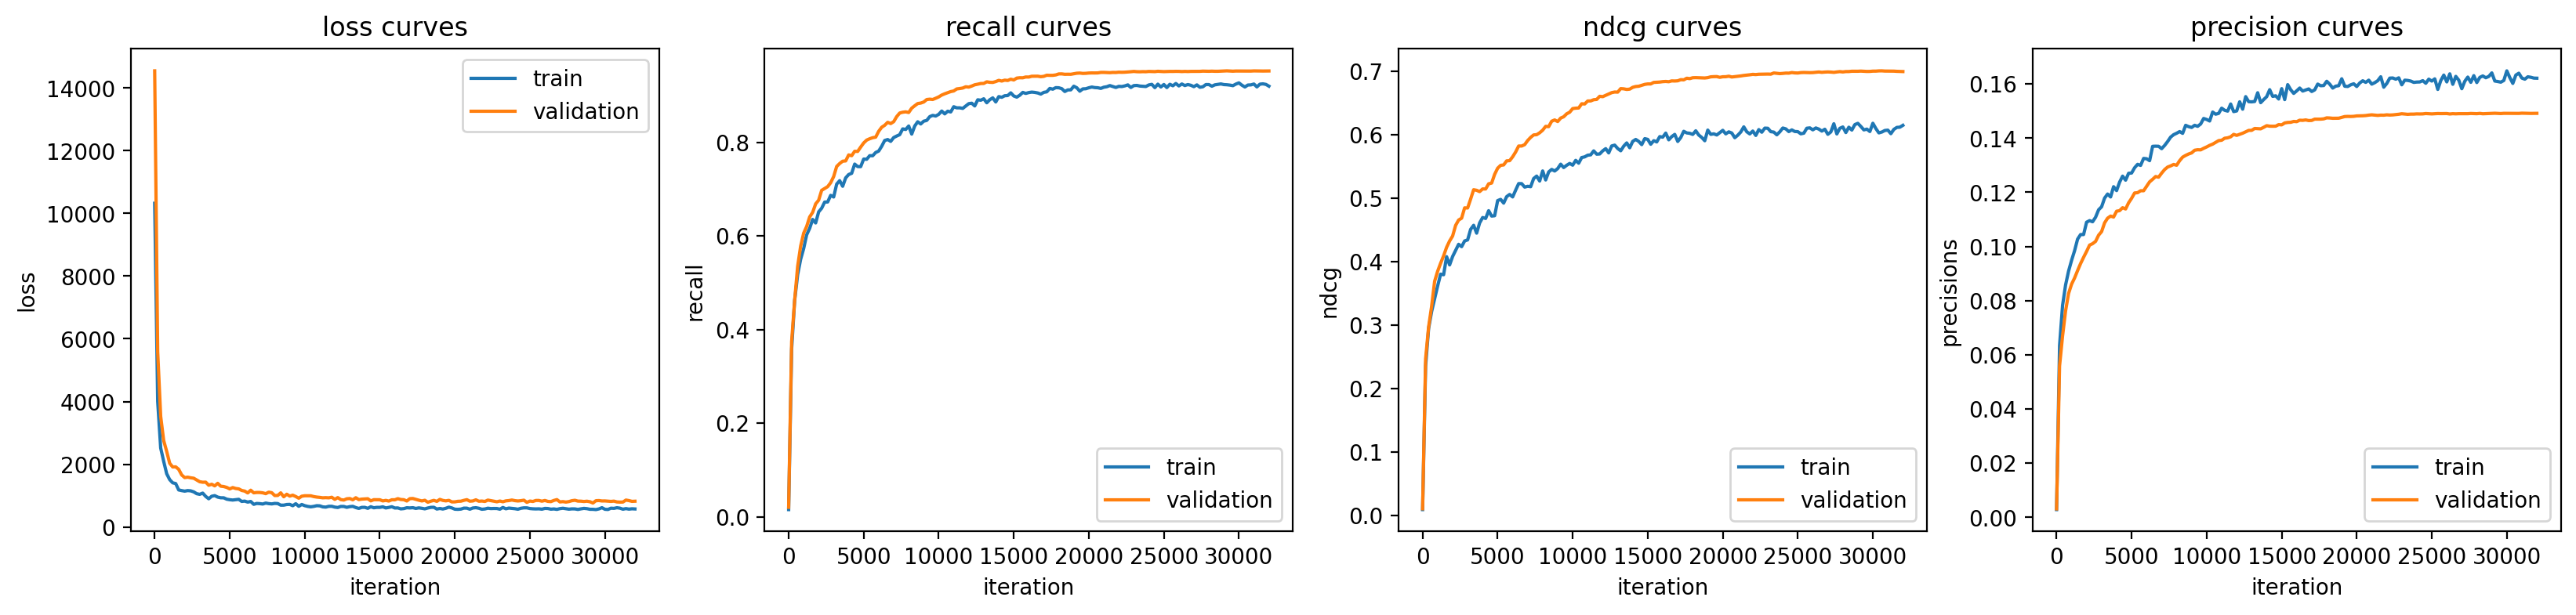

In [21]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,4), dpi=200)

# ax[0].plot(iters, train_msg_losses, label='msg_train')
ax[0].plot(iters, train_losses, label='train')
ax[0].plot(iters, val_losses, label='validation')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')
ax[0].set_title('loss curves')
ax[0].legend()

ax[1].plot(iters, train_recalls, label='train')
ax[1].plot(iters, val_recalls, label='validation')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('recall')
ax[1].set_title('recall curves')
ax[1].legend()

ax[2].plot(iters, train_ndcgs, label='train')
ax[2].plot(iters, val_ndcgs, label='validation')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('ndcg')
ax[2].set_title('ndcg curves')
ax[2].legend()

ax[3].plot(iters, train_precisions, label='train')
ax[3].plot(iters, val_precisions, label='validation')
ax[3].set_xlabel('iteration')
ax[3].set_ylabel('precisions')
ax[3].set_title('precision curves')
ax[3].legend()

plt.show()

## Evaluation

In [22]:
model.eval()
user_pos_items = get_user_positive_items(edge_index)
id_to_course = {v: k for k, v in courseIds.items()}
user_pos_items[35]

[2120,
 2221,
 2222,
 1905,
 2223,
 2224,
 2225,
 2043,
 2226,
 2227,
 1931,
 2228,
 1910,
 2087,
 1923,
 2229,
 1960,
 2062,
 1979,
 1910,
 2230,
 1925,
 1926,
 2231]

In [23]:
def make_predictions(user, num_recs, only_new=True):
    e_u = model.users_emb_final[user]
    scores = model.items_emb_final @ e_u

    values, indices = torch.topk(scores, k=len(user_pos_items[user]) + num_recs)
    indices = [index.item() for index in indices]
    
    print(f"Here are classes user {user} has already taken:")
    for index in user_pos_items[user]:
        print(id_to_course[index])
    print()
    
    print(f'Here are the top recommended courses{" (* means already taken)" if not only_new else ""}:')
    i = 0
    not_yet_taken = 0
    while not_yet_taken < num_recs:
        if not only_new or indices[i]+num_users not in user_pos_items[user]:
            print(f"{id_to_course[indices[i]+num_users]} {'(*)' if indices[i]+num_users in user_pos_items[user] else ''}")
        if indices[i]+num_users not in user_pos_items[user]:
            not_yet_taken += 1
        i += 1

In [24]:
USER_ID = 7
NUM_RECS = 10

make_predictions(USER_ID, NUM_RECS)

Here are classes user 7 has already taken:
CHEM121
MED182
SYMSYS1
CHEM141
EMED127
HUMBIO154C
MUSIC12A
STS1

Here are the top recommended courses:
BIO84 
BIO82 
CHEM33 
PSYCH1 
LINGUIST145 
BIO45 
BIO83 
BIOE44 
MATH21 
BIO86 


In [25]:
USER_ID = 1
NUM_RECS = 10

make_predictions(USER_ID, NUM_RECS)

Here are classes user 1 has already taken:
COMM172
ENGLISH50
PSYC135
PSYCH101
PSYCH195

Here are the top recommended courses:
PSYCH60 
PSYCH144 
PSYCH30 
PSYCH90 
PSYCH60A 
PSYCH80 
PSYCH95 
PSYCH147 
PSYCH138 
PSYC139 


In [26]:
USER_ID = 557
NUM_RECS = 10

make_predictions(USER_ID, NUM_RECS)

Here are classes user 557 has already taken:
CS106B
ESF17
MATH51
CHEM29N
COLLEGE102
CS103
DATASCI112
SYMSYS1
CS109
CS161
CS41
PATH51
CS107
CS148
PHYSICS21
SPECLANG150A
CLASSICS151
CS111
EMED127
PHYSICS23
SPECLANG150B
PWR2STA
SPECLANG150C
ARCHLGY151
CLASSICS21Q
CS198
PSYCH70
PSYCH95

Here are the top recommended courses:
PSYC135 
PSYCH1 
CS106L 
STS1 
CS106A 
MATH104 
COLLEGE101 
ARTSTUDI165A 
CS124 
PSYCH80 
